In [ ]:
#import libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2 as cv 
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Lambda,Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.nn import local_response_normalization
# metrics 
from tensorflow.keras.metrics import categorical_crossentropy
# optimization method
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
from google.colab.patches import cv2_imshow



In [ ]:
NUM_LABELS = 29
BATCH_SIZE = 256
epochs = 30
initializer = GlorotUniform()
ALPHABET = ["None-لاشيئ","alef-ألف", "beh-باء", "teh-تاء", "theh-ثاء", "jeem-جيم", "hah-حاء", "khah-خاء", "dal-دال", "thal-ذال",
        "reh-راء", "zah-زاى", "seen-سين", "sheen-شين", "sad-صاد", "dad-ضاد", "tah-طاء", "zah-ظاء", "ain-عين",
        "ghain-غين", "feh-فاء", "qaf-قاف", "kaf-كاف", "lam-لام", "meem-ميم", "noon-نون", "heh-هاء", "waw-واو", "yeh-ياء"]

In [ ]:
# some functions 

def load_data(PATH_TO_DATA):
  df = pd.read_csv(PATH_TO_DATA)
  images = np.array(df.iloc[:,:])
  X_data = []
  for index in range(images.shape[0]):
    sample_image = np.reshape(images[index],(32,32),'F')
    X_data = np.stack([*X_data, sample_image])
    
  print(X_data.shape)
  return X_data
 
def load_label(PATH_TO_LABEL):
    df = pd.read_csv(PATH_TO_LABEL)
    # read pixels 
    images = np.array(df.iloc[:,:])
    print(images.shape)
    return images

def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

def preprocess_data(X_train, y_train, X_test, y_test):
  # reshape images to the required size of Keras
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
  
  # convert image values from integers to floats
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  
  # normalization
  X_train = X_train/255.0
  X_test_norm = X_test/255.0
  
  # One-hot encoding label 
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  
  return X_train, y_train, X_test, y_test 

def summary_history(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

def arabicOCRmodel():

    model = Sequential()
    #CONV LAYER 1
    model.add(Conv2D(filters=80 , kernel_size = (5, 5), activation='relu',kernel_initializer=initializer,kernel_regularizer =l2(l=0.0000005),input_shape = (32,32,1)))
    #MAX POOLING LAYER 1
    model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))
    #LRN
    model.add(Lambda(local_response_normalization))
    #CONV LAYER 2
    model.add(Conv2D(filters=64 ,kernel_size = (5, 5), activation='relu',kernel_initializer=initializer,kernel_regularizer =l2(l=0.0000005)))
    #MAX POOLING LAYER 2
    model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))
    #LRN
    model.add(Lambda(local_response_normalization)) 
    # Flatten layer  
    model.add(Flatten())

    # The first fully connected layer 
    model.add(Dense(1024, activation = 'relu',kernel_initializer=initializer))
    #Dropout for overfitting
    model.add(Dropout(0.4))
   
    # The output layer  
    model.add(Dense(NUM_LABELS, activation = 'softmax',kernel_initializer=initializer))
  
    # opt = SGD(learning_rate = 0.001)
    opt = Adam(learning_rate=0.001)

    model.compile(loss = 'categorical_crossentropy', 
                optimizer = opt, 
                metrics = ['accuracy']) 
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def train_model(model, X_train, y_train, X_test, y_test, epochs = 50, batch_size = 128):
  # Rescaling all training and testing data
  X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)
  print(X_train.shape)
  print(y_train.shape)
  print(X_test.shape)
  print(y_test.shape)
  
  # Fitting the model on the training set
  history = model.fit(X_train,y_train,epochs=epochs,batch_size = batch_size,steps_per_epoch = X_train.shape[0]//batch_size,
                      validation_data=(X_test,y_test),validation_steps = X_test.shape[0]//batch_size , verbose = 1)
  
   # evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  summary_history(history)


In [ ]:
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks"


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
X_train = load_data("csvTrainImages 13440x1024.csv")
y_train = load_label("csvTrainLabel 13440x1.csv")
X_test  = load_data("csvTestImages 3360x1024.csv")
y_test = load_label("csvTestLabel 3360x1.csv")


(13439, 32, 32)
(13439, 1)
(3359, 32, 32)
(3359, 1)


In [ ]:
ALPHABET[0]

'None-لاشيئ'

2
19
9
1
11
4
24
19


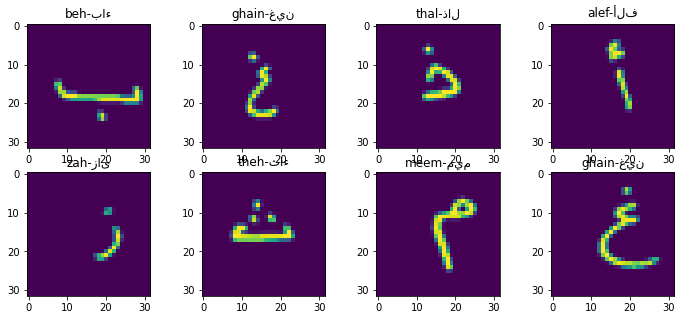

In [ ]:
plt.figure(figsize = (12,5))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240+1+i)
  plt.imshow(X_train[ind])
  print(y_train[ind][0])  
  plt.title(ALPHABET[y_train[ind][0]])

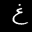

In [ ]:
cv2_imshow(X_train[ind])

In [ ]:
OCR_model = arabicOCRmodel()
OCR_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 80)        2080      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 80)       0         
 g2D)                                                            
                                                                 
 lambda_12 (Lambda)          (None, 14, 14, 80)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 10, 64)        128064    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 lambda_13 (Lambda)          (None, 5, 5, 64)         

(13439, 32, 32, 1)
(13439, 29)
(3359, 32, 32, 1)
(3359, 29)
Epoch 1/30
52/52 [==============================] - 2s 38ms/step - loss: 2.1928 - accuracy: 0.3408 - val_loss: 1.4723 - val_accuracy: 0.5364
Epoch 2/30
52/52 [==============================] - 2s 31ms/step - loss: 0.9655 - accuracy: 0.6908 - val_loss: 0.8663 - val_accuracy: 0.7046
Epoch 3/30
52/52 [==============================] - 2s 31ms/step - loss: 0.6048 - accuracy: 0.8035 - val_loss: 0.8652 - val_accuracy: 0.7166
Epoch 4/30
52/52 [==============================] - 2s 31ms/step - loss: 0.4391 - accuracy: 0.8596 - val_loss: 0.8175 - val_accuracy: 0.7362
Epoch 5/30
52/52 [==============================] - 2s 31ms/step - loss: 0.3549 - accuracy: 0.8877 - val_loss: 0.7869 - val_accuracy: 0.7449
Epoch 6/30
52/52 [==============================] - 2s 31ms/step - loss: 0.2715 - accuracy: 0.9128 - val_loss: 0.6308 - val_accuracy: 0.7993
Epoch 7/30
52/52 [==============================] - 2s 31ms/step - loss: 0.2337 - accuracy: 0.

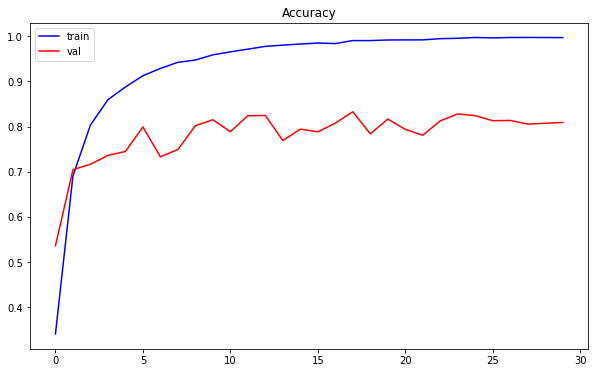

In [ ]:
train_model(OCR_model, X_train, y_train, X_test, y_test,epochs = 30, batch_size = BATCH_SIZE)


In [ ]:
OCR_model.save("./")
tf.keras.models.save_model(OCR_model,'./save')
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
OCR_model.save_weights("ImageClassifier.h5")

In [ ]:
import numpy as np

# predict labels for the test set
y_test_pred = []
for i in range(len(X_test)):
  img = X_test[i]
  img = img.reshape(1,32,32,1)
  img = img.astype('float32')
  img = img/255.0
  # one-hot vector output
  vec_p = OCR_model.predict(img)
  # determine the label corresponding to vector vec_p
  y_p = np.argmax(vec_p)
  y_test_pred.append(y_p)
  
# convert y_test_pred from list to array
y_test_pred = np.asarray(y_test_pred)

Text(240.0, 0.5, 'True classes')

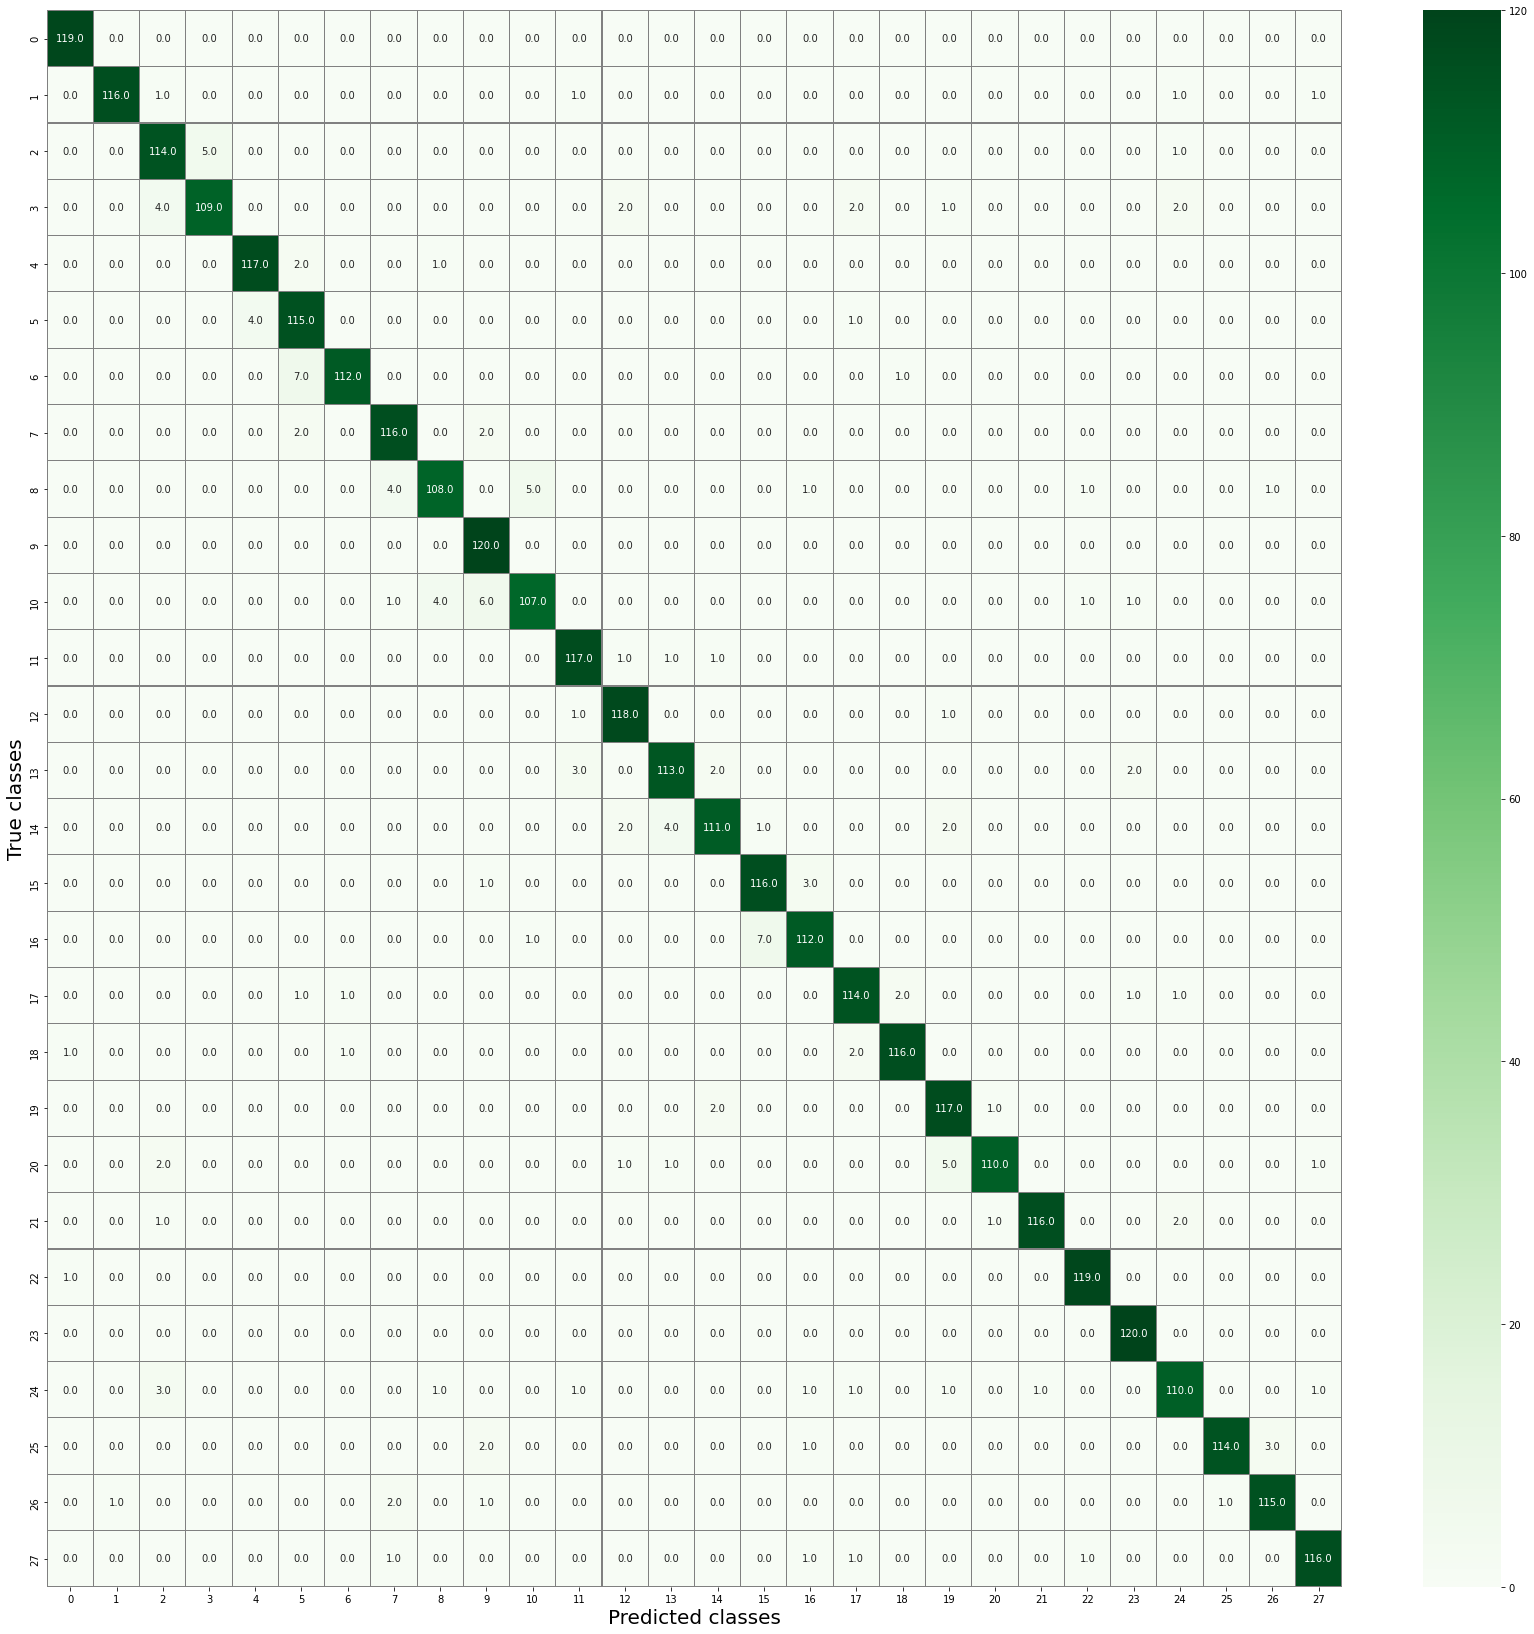

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

con_mat = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize = (29,29))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

Text(0.5, 1.0, '6')

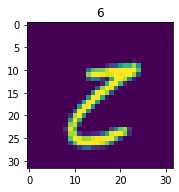

In [ ]:
# # all categories
# cates =  ["alef-ألف", "beh-باء", "teh-تاء", "theh-ثاء", "jeem-جيم", "hah-حاء", "khah-خاء", "dal-دال", "thal-ذال",
#         "reh-راء", "zah-زاى", "seen-سين", "sheen-شين", "sad-صاد", "dad-ضاد", "tah-طاء", "zah-ظاء", "ain-عين",
#         "ghain-غين", "feh-فاء", "qaf-قاف", "kaf-كاف", "lam-لام", "meem-ميم", "noon-نون", "heh-هاء", "waw-واو", "yeh-ياء"];

plt.figure(figsize = (12,7))
# for i in np.arange(8):
  # ind = random.randint(0,len(X_test))
ind=10

img = X_test[ind]
img = img.reshape(1,32,32,1)
img = img.astype('float32')
img = img/255.0
# one-hot vector output
vec_p = OCR_model.predict(img)
# determine the label corresponding to vector vec_p
y_p = np.argmax(vec_p)
plt.subplot(240+1)
plt.imshow(X_test[ind])
plt.title(y_p)

(382, 356)


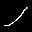

Text(0.5, 1.0, 'reh-راء')

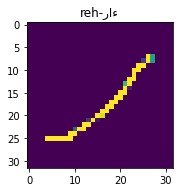

In [ ]:
img = cv.imread('UNKNOWN1.png',0)
print(img.shape)
down_width = 32
down_height = 32
down_points = (down_width, down_height)
resized_down = cv.resize(img, down_points, interpolation= cv.INTER_LINEAR)
resized_down = cv.bitwise_not(resized_down)
cv2_imshow(resized_down)
resized_down = resized_down.reshape(1,32,32,1)
resized_down = resized_down.astype('float32')
resized_down = resized_down/255.0
vec_p = OCR_model.predict(resized_down)
# determine the label corresponding to vector vec_p
y_p = np.argmax(vec_p)
plt.figure(figsize = (12,7))
plt.subplot(240+1)
plt.imshow(resized_down.reshape(32,32))
plt.title(ALPHABET[y_p])